In [6]:
import pandas as pd
import numpy as np
import lhapdf
import sys
import os

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
sys.path.insert(0, "/Users/rocconoe/local/lib/python3.9/site-packages")
lhapdf.pathsPrepend("/home/sam/miniconda3/pkgs/share/LHAPDF")

> # Momentum distribution:

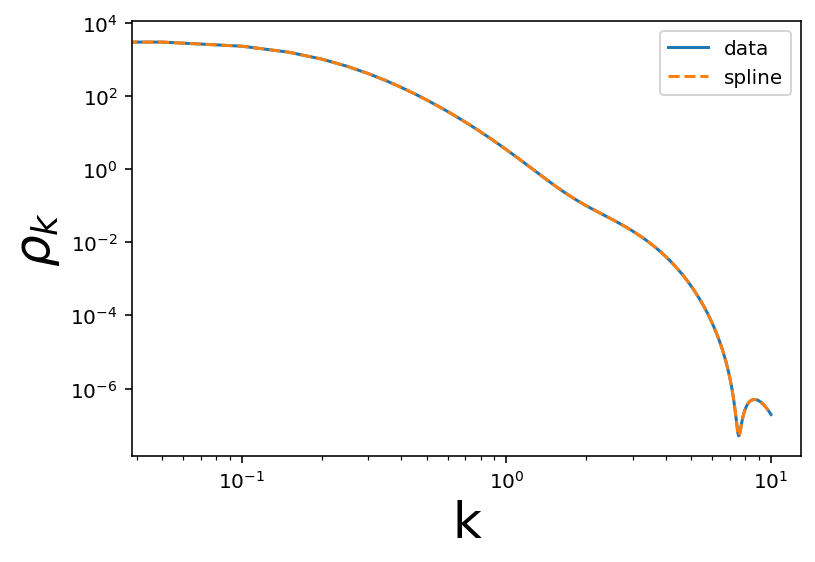

In [8]:
momentum = pd.read_csv('nk_deut.dat', sep='\s+', names=['k','rs','rd','rk'], dtype=np.float64,skiprows=2)
"""Plot the momentum distribution."""
plt.figure(figsize=(6,4));plt.rc('axes', labelsize=25, titlesize=30);plt.plot(momentum['k'],momentum['rk'],label='data');
ps = interp1d(momentum['k'],momentum['rk'], kind='cubic');xnew = np.linspace(0, 10, 200);plt.plot(xnew, ps(xnew),'--',label='spline')
plt.xscale('log');plt.yscale('log');plt.xlabel('k');plt.ylabel(r'$\rho_k$');plt.legend();plt.show()

In [9]:
"""Normalization check (dk=0.05 by default):"""
pf = (4*np.pi)/pow(2*np.pi,3) ; norm = 0 ; dk = 0.05
for ik,k in enumerate(momentum['k']):
    norm += pow(k,2)*dk*momentum['rk'][ik]
print('The normalized momentum distribution roughly equates to {n:.3f}'.format(n=norm*pf))

The normalized momentum distribution roughly equates to 1.000


> # Function & Class Definitions:

In [ ]:
class PDF:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name, set_id):
        self.pdf = lhapdf.mkPDF(name, set_id)
        self.quarks = {'d': 1, 'u': 2, 's': 3, 'c': 4, 'b': 5,
                       'db': -1, 'ub': -2, 'sb': -3, 'cb': -4, 'bb': -5}
        
    def __call__(self, i, xs, ys, E):
        if isinstance(i, str):
            i = self.quarks[i]
        xfx = np.zeros([len(xs), len(ys)])
        for ix, x in enumerate(xs):
            for iy, y in enumerate(ys):
                q           = np.sqrt(2*m_p*E*x*y)
                xfx[ix, iy] = self.pdf.xfxQ(i, x, q)
        return xfx

In [ ]:
def q2f(E, xs, ys):
    """
    Takes arrays of x and y values, and incoming electron beam energy. 
    Outputs corresponding array of q**2's.
    """
    q2 = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            q2[ix,iy] = 2*m_p*E*x*y # Thank you Noemi - derived in notes!
    return q2

In [ ]:
def F2_ep(pdf, E, xs, ys):
    """
    electron-proton scattering F2 expression. (7.4.56)
    """
    series = (4/9)*(pdf("u",xs,ys,E) + pdf("ub",xs,ys,E)) +\
             (1/9)*(pdf("d",xs,ys,E) + pdf("db",xs,ys,E)) +\
             (1/9)*(pdf("s",xs,ys,E) + pdf("sb",xs,ys,E))
    return series

In [ ]:
def F2_en(pdf, E, xs, ys):
    """
    electron-neutron scattering F2 expression. (7.4.57)
    """
    series = (4/9)*(pdf("d",xs,ys,E) + pdf("db",xs,ys,E)) +\
             (1/9)*(pdf("u",xs,ys,E) + pdf("ub",xs,ys,E))+\
             (1/9)*(pdf("s",xs,ys,E) + pdf("sb",xs,ys,E))
    return series

In [ ]:
def F1_ep(pdf, E, xs, ys):
    """
    Quiggs Eq. (7.4.52), electron-proton case.
    Takes LHAPDF data set, incoming electron beam energy, array xs and ys of x and y values.
    """
    f1 = F2_ep(pdf,E,xs,ys)
    for ix, x in enumerate(xs):
        f1[ix] *= (1/(2*x))       # this is suspect to break with array formats?
    return f1

In [ ]:
def F1_en(pdf, E, xs, ys):
    """
    electron-neutron case: very similar to F1_ep() function.
    """
    f1 = F2_en(pdf,E,xs,ys)
    for ix, x in enumerate(xs):
        f1[ix] *= (1/(2*x))       # this is suspect to break with array formats?
    return f1

In [ ]:
a         = 1/137    # fine structure constant.
prefactor = 4*np.pi*(a**2)
m_p       = 0.938    # mass of proton in GeV.
m_n       = 0.939    # mass of neutron in GeV.
M_N       = m_p + m_n

> # Messing with Deuteron:

In [38]:
def E(p,nucleon_mass):
    return np.sqrt(pow(p,2)+pow(nucleon_mass,2))

In [ ]:
"""We could use simpy and the spline object of the momentum distribtion."""
def p_integral(p,y,E,θ_p,q):
    # cross product squared of p and q.
    CP2   = E(p,m_n)*y*E - p*np.cos(θ_p)*np.sqrt(pow(q,2)+pow(y*E,2)) 
    W     = 1 # some energy transfer variable.
    funct = (F1_en(pdf, E, xs, ys)/m_n + 1/2*F2_en(pdf, E, xs, ys)/W * CP2)
    
    pf = (4*np.pi)/pow(2*np.pi,3) ; norm = 0 ; dk = 0.05
    for ik,k in enumerate(momentum['k']):
        norm += pow(k,2)*dk*momentum['rk'][ik]
    return ps(p) * m_n/E(p,m_n) * funct # this needs to be fixed.

In [ ]:
"""Assuming q vector is along z-axis:"""
def neutron_contribution():
    return M_N * p_integral(p)

In [ ]:
def proton_contribution():
    ???

In [10]:
import sympy as sp

In [52]:
p = sp.Symbol('p')
sp.integrate((p**2+1)**(1/2),(p,0,1))
# check definite integration using sympy.

1.0*hyper((-0.5, 1/2), (3/2,), -1)

>Although only limited mathematical functions are likely to work.
>
>If you only care about the numerical answer, you could try scipy's integrate.quad() (or scipy.integrate.dblquad()) which will do numerical integration, and can tackle a broader set of functions within a small error.

```python
scipy.integrate.quad(my_func, a, b)
```

In [29]:
from scipy.interpolate import UnivariateSpline
x = np.linspace(0, 3, 11)
y = x**2
spl = UnivariateSpline(x, y)
spl.integral(0, 3)

9.0

In [36]:
mom = UnivariateSpline(momentum['k'],momentum['rk'])
mom.integral(0, 10) 
# this may be the easiest to get a value for the momentum?

560.3986593664031